In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc, ConfusionMatrixDisplay

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
df = pd.read_csv("./default_of_credit_card_clients.csv", header=1)
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

Для удобства переименуем некоторые столбцы. Так, например, выбивается столбец ***PAY_0***, поскольку каждому номеру столбцов ***PAY_n*** соответствует столбцы ***BILL_AMTn*** и ***PAY_AMTn***. 
<br>
Название поля ***'default payment next month'*** слишком длинное, переименуем и его для краткости.

In [3]:
df.rename(
    columns={"PAY_0": "PAY_1", "default payment next month": "DFLT_PAY"},
    inplace=True
)

In [4]:
df.describe().T

count           mean            std       min       25%  \
ID         30000.0   15000.500000    8660.398374       1.0   7500.75   
LIMIT_BAL  30000.0  167484.322667  129747.661567   10000.0  50000.00   
SEX        30000.0       1.603733       0.489129       1.0      1.00   
EDUCATION  30000.0       1.853133       0.790349       0.0      1.00   
MARRIAGE   30000.0       1.551867       0.521970       0.0      1.00   
AGE        30000.0      35.485500       9.217904      21.0     28.00   
PAY_1      30000.0      -0.016700       1.123802      -2.0     -1.00   
PAY_2      30000.0      -0.133767       1.197186      -2.0     -1.00   
PAY_3      30000.0      -0.166200       1.196868      -2.0     -1.00   
PAY_4      30000.0      -0.220667       1.169139      -2.0     -1.00   
PAY_5      30000.0      -0.266200       1.133187      -2.0     -1.00   
PAY_6      30000.0      -0.291100       1.149988      -2.0     -1.00   
BILL_AMT1  30000.0   51223.330900   73635.860576 -165580.0   3558.75   
BILL_AMT2  30000.0   49179.075167   71173.768783  -69777.0   2984.75   
BILL_AMT3  30000.0   47013.154800   69349.387427 -157264.0   2666.25   
BILL_AMT4  30000.0   43262.948967   64332.856134 -170000.0   2326.75   
BILL_AMT5  30000.0   40311.400967   60797.155770  -81334.0   1763.00   
BILL_AMT6  30000.0   38871.760400   59554.107537 -339603.0   1256.00   
PAY_AMT1   30000.0    5663.580500   16563.280354       0.0   1000.00   
PAY_AMT2   30000.0    5921.163500   23040.870402       0.0    833.00   
PAY_AMT3   30000.0    5225.681500   17606.961470       0.0    390.00   
PAY_AMT4   30000.0    4826.076867   15666.159744       0.0    296.00   
PAY_AMT5   30000.0    4799.387633   15278.305679       0.0    252.50   
PAY_AMT6   30000.0    5215.502567   17777.465775       0.0    117.75   
DFLT_PAY   30000.0       0.221200       0.415062       0.0      0.00   

                50%        75%        max  
ID          15000.5   22500.25    30000.0  
LIMIT_BAL  140000.0  240000.00  1000000.0  
SEX             2.0       2.00        2.0  
EDUCATION       2.0       2.00        6.0  
MARRIAGE        2.0       2.00        3.0  
AGE            34.0      41.00       79.0  
PAY_1           0.0       0.00        8.0  
PAY_2           0.0       0.00        8.0  
PAY_3           0.0       0.00        8.0  
PAY_4           0.0       0.00        8.0  
PAY_5           0.0       0.00        8.0  
PAY_6           0.0       0.00        8.0  
BILL_AMT1   22381.5   67091.00   964511.0  
BILL_AMT2   21200.0   64006.25   983931.0  
BILL_AMT3   20088.5   60164.75  1664089.0  
BILL_AMT4   19052.0   54506.00   891586.0  
BILL_AMT5   18104.5   50190.50   927171.0  
BILL_AMT6   17071.0   49198.25   961664.0  
PAY_AMT1     2100.0    5006.00   873552.0  
PAY_AMT2     2009.0    5000.00  1684259.0  
PAY_AMT3     1800.0    4505.00   896040.0  
PAY_AMT4     1500.0    4013.25   621000.0  
PAY_AMT5     1500.0    4031.50   426529.0  
PAY_AMT6     1500.0    4000.00   528666.0  
DFLT_PAY        0.0       0.00        1.0

Получим информацию о типе данных и убедимся в отсутствии битых полей

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [6]:
df.isna().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DFLT_PAY     0
dtype: int64

Можно заметить, что поля ***SEX, EDUCATION, MARRIAGE, PAY_n*** категориальные.

Посмотрим на то, как хорошо сбалансирован наш датасет.

## Визуализация

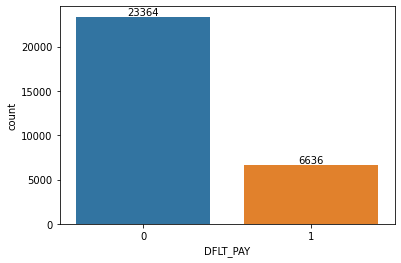

In [7]:
ax = sns.countplot(x=df.DFLT_PAY)
ax.bar_label(ax.containers[0]);

Видно, что у нас несбалансированный датасет - количество элементов класса ***'1'*** в 3.5 раза меньше числа элементов класса ***'0'***.

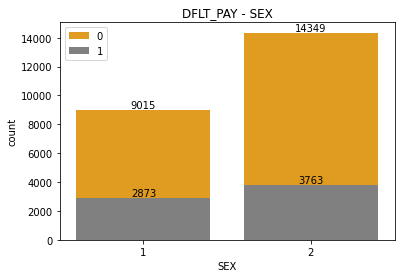

In [8]:
ax = plt.subplots()
ax = sns.countplot(x=df[df.DFLT_PAY == 0].SEX, color='orange', label='0')
ax = sns.countplot(x=df[df.DFLT_PAY == 1].SEX, color='gray', label='1')

for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])
    
plt.title("DFLT_PAY - SEX")
plt.legend();

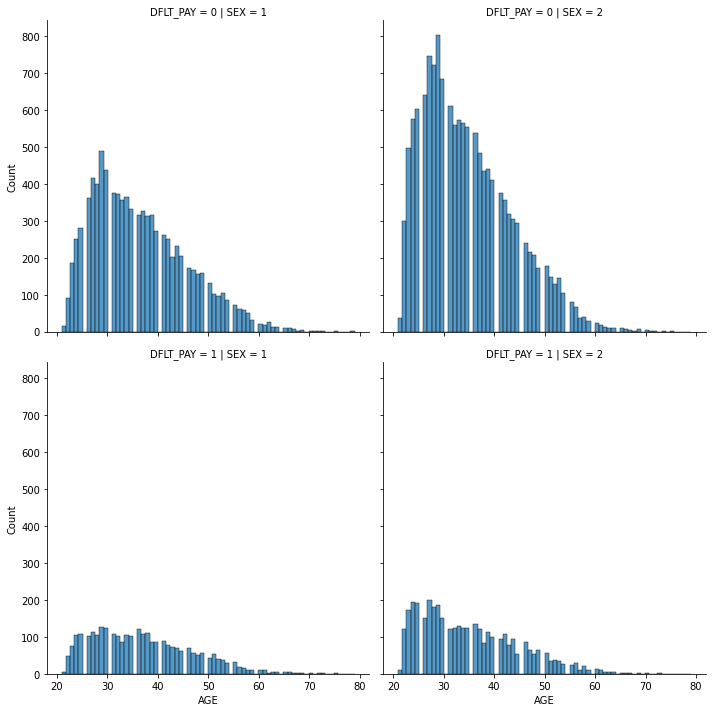

In [9]:
sns.displot(
    data=df, x="AGE",
    row="DFLT_PAY", col="SEX",
);

Как видно из графика выше, количество людей пола, класс которых соответсвует ***2***, больше; из этого можно предположить, что они берут кредит чаще.

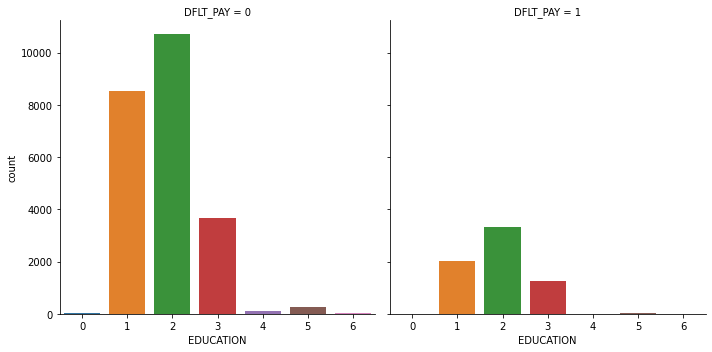

In [10]:
sns.catplot(
    data=df, col="DFLT_PAY", 
    x="EDUCATION", kind="count"
);

Как видно из распределения людей по их полученному образованию, те, кто имеют классы ***1, 2, 3*** более склонны брать кредит. При этом эти группы людей доминируют как среди тех, кто отдал в последующем деньги, так и среди тех, кто не смог этого сделать. Наибольшее число людей с классом ***2***.

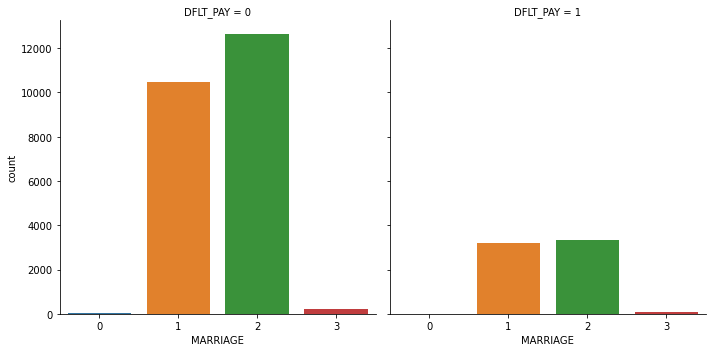

In [11]:
sns.catplot(
    data=df, col="DFLT_PAY", 
    x="MARRIAGE", kind="count"
);

Неясно, что означают данные категории. Допустим, в браке, холост, неизвестно и что-то еще. Можно заменить на 2 состояния: в браке или холостой. Однако непонятно, что объединять, поэтому оставим так.

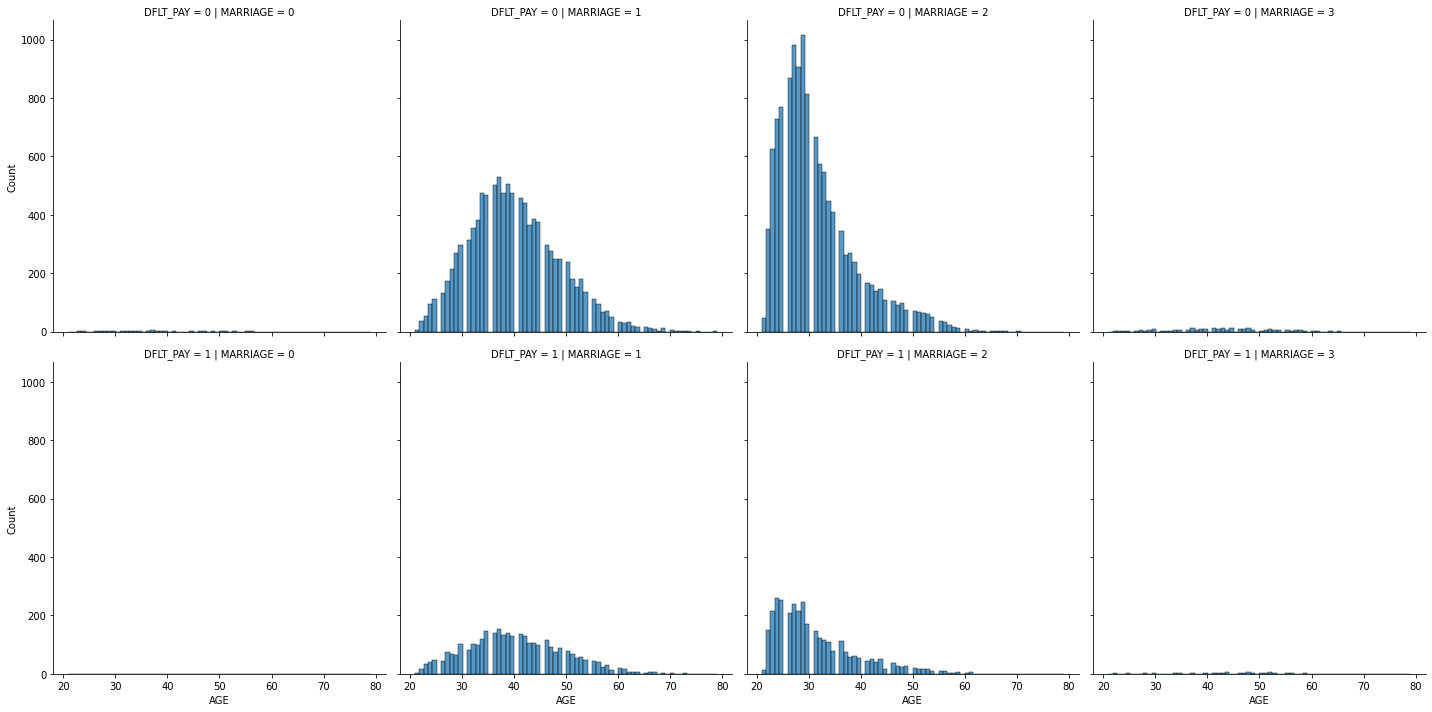

In [12]:
sns.displot(
    data=df, x="AGE",
    row="DFLT_PAY", col="MARRIAGE",
);

Из распределения (по браку) выше можно сделать предположение, что люди с классами ***1, 2*** чаще берут кредит, но при этом чаще не могут вернуть деньги банку люди с классом ***2***.

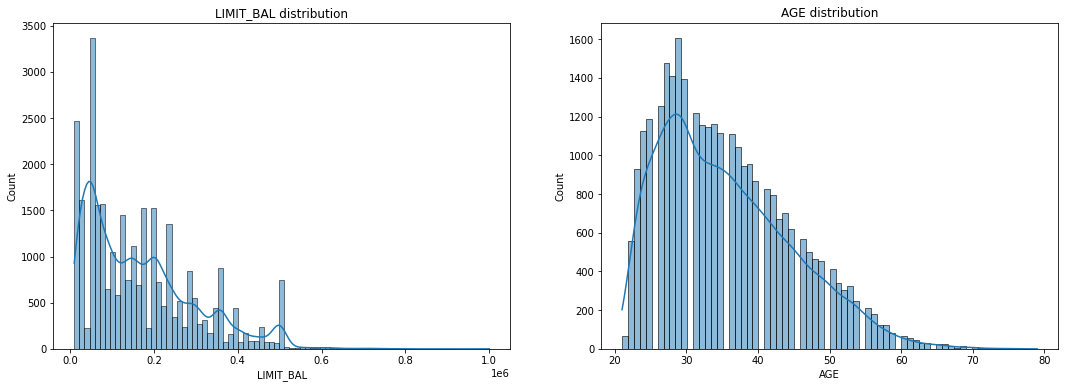

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

xs = ["LIMIT_BAL", "AGE"]

for i in range(len(xs)):
    ax[i].set_title(f"{xs[i]} distribution")
    sns.histplot(data=df, x=xs[i], kde=True, ax=ax[i])

Благодаря построенным распределениям ***LIMIT_BAL*** и ***AGE*** соответственно. На графике слева можно заметить, что значения кредитов сосредоточено преимущественно в диапазоне от 10000 до 240000 у.е. На соседнем графике видно, что возраст большинства людей, берущих кредит, находится в примерной области от 20 до 45 лет.

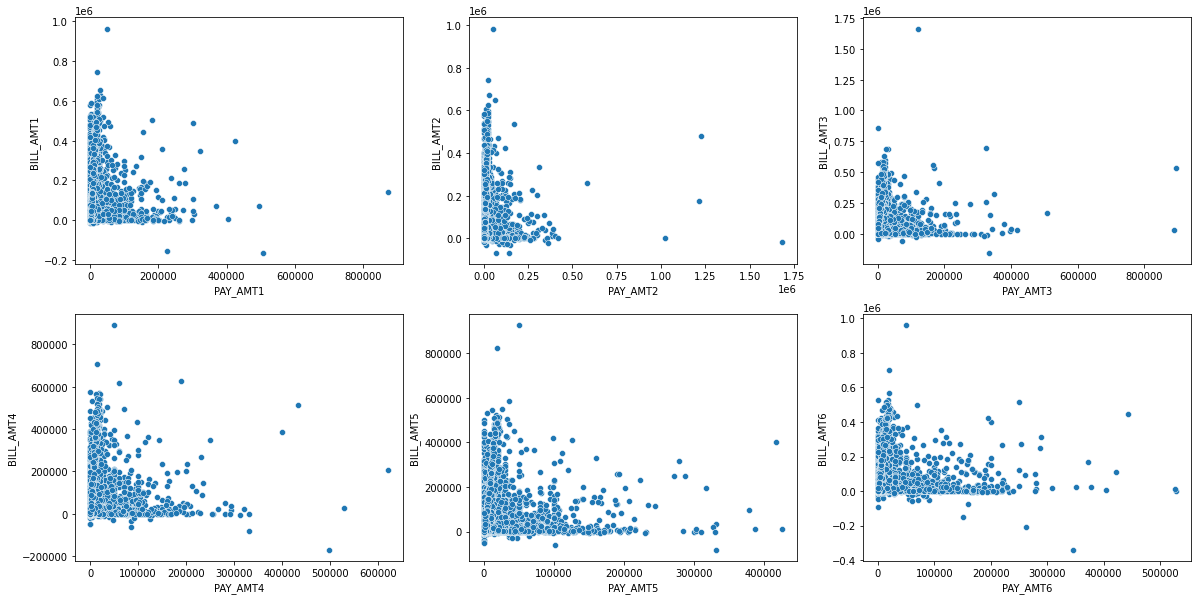

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(axes)):
    for j in range(len(axes[i])):
        idx = i * len(axes[i]) + j + 1
        sns.scatterplot(data=df, x=f"PAY_AMT{idx}", y=f"BILL_AMT{idx}", ax=axes[i, j])

Видно, что при большой задолженности, как бы это странно ни было, сумма выплаты небольшая.

In [15]:
def plot_histograms(df, columns, rows, cols, figsize=(20, 10), bins=30, kde=True):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            sns.histplot(data=df, x=columns[idx], ax=axes[i, j], bins=bins, kde=kde)

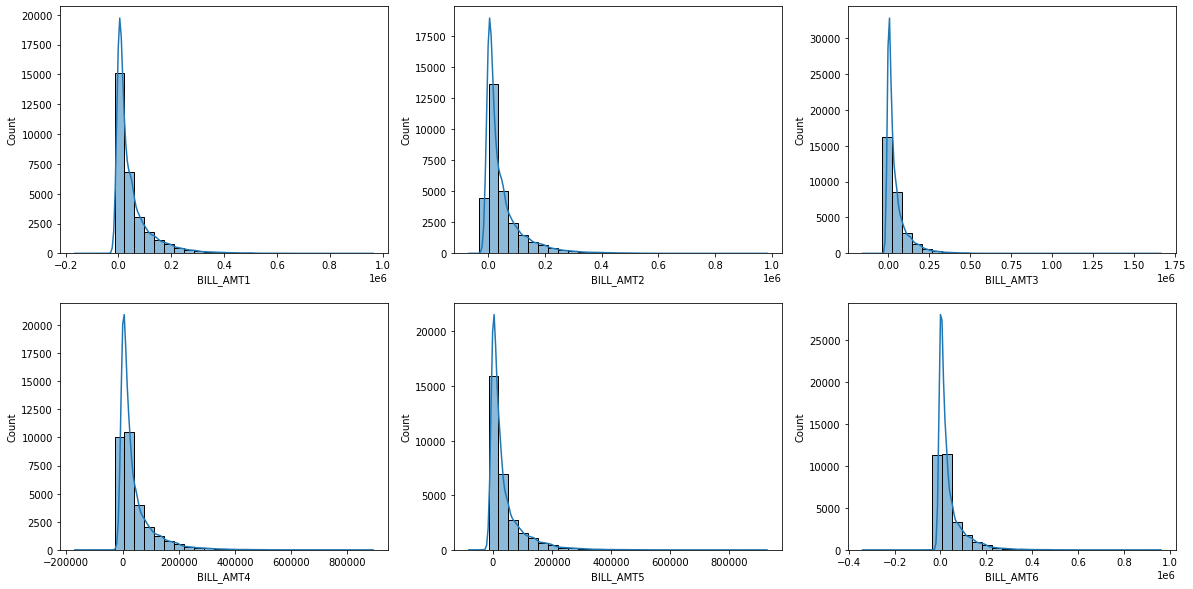

In [16]:
plot_histograms(
    df=df,
    columns=[f"BILL_AMT{i}" for i in range(1, 7)],
    rows=2, cols=3
)

Непонятно, правда, почему сумма, которую необходимо заплатить порой может быть отрицательной...

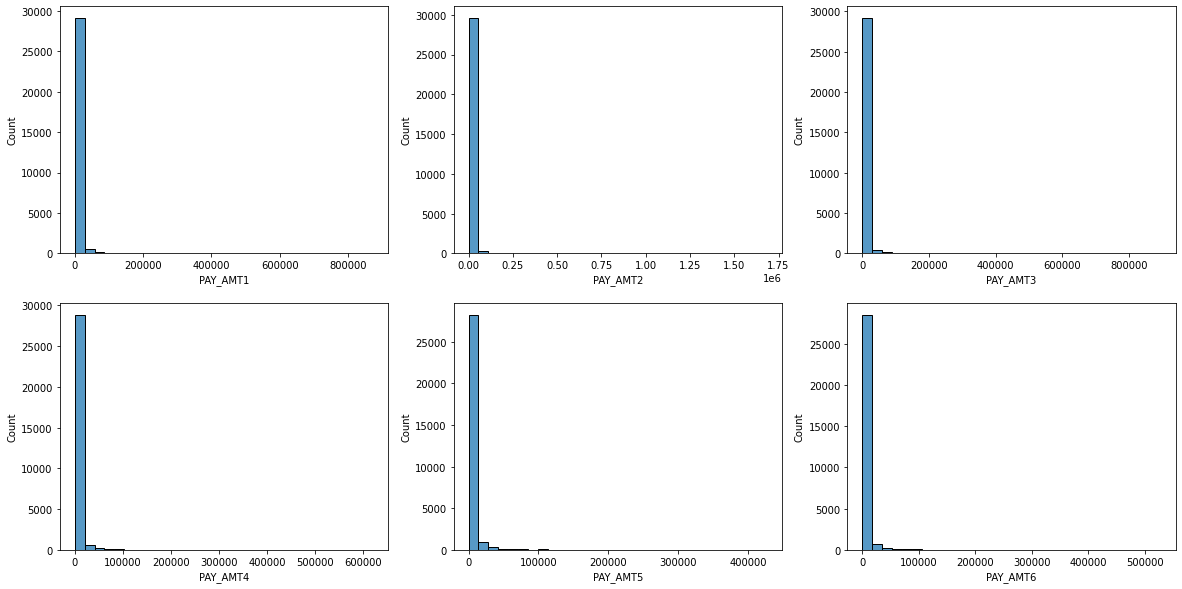

In [17]:
plot_histograms(
    df=df,
    columns=[f"PAY_AMT{i}" for i in range(1, 7)],
    rows=2, cols=3,
    kde=False
)

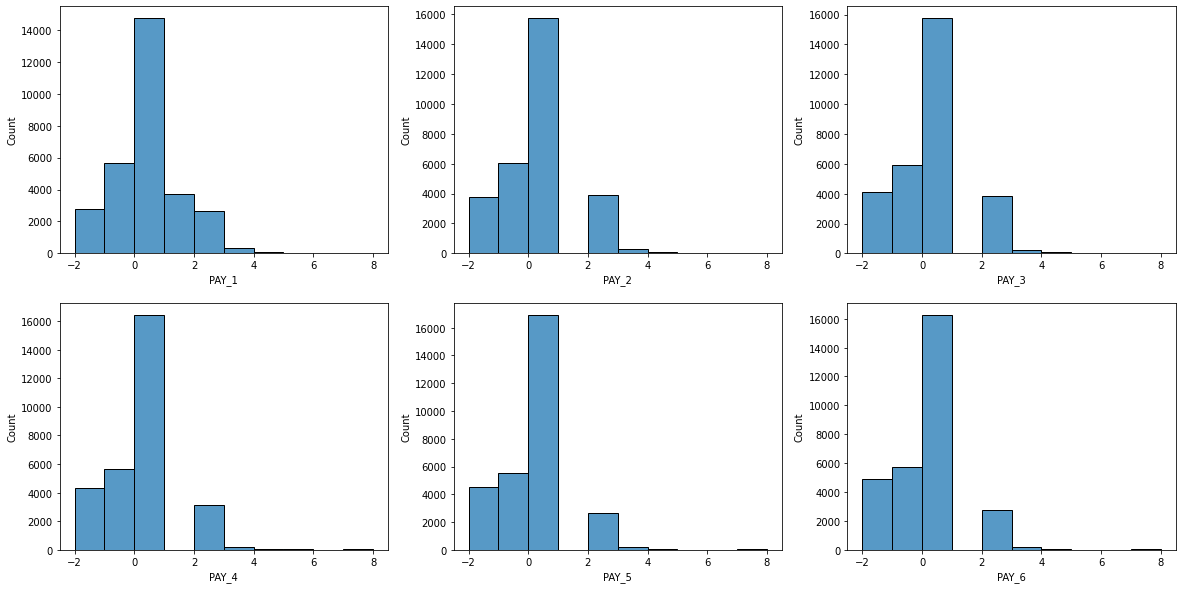

In [18]:
plot_histograms(
    df=df,
    columns=[f"PAY_{i}" for i in range(1, 7)],
    rows=2, cols=3,
    kde=False, bins=10
)

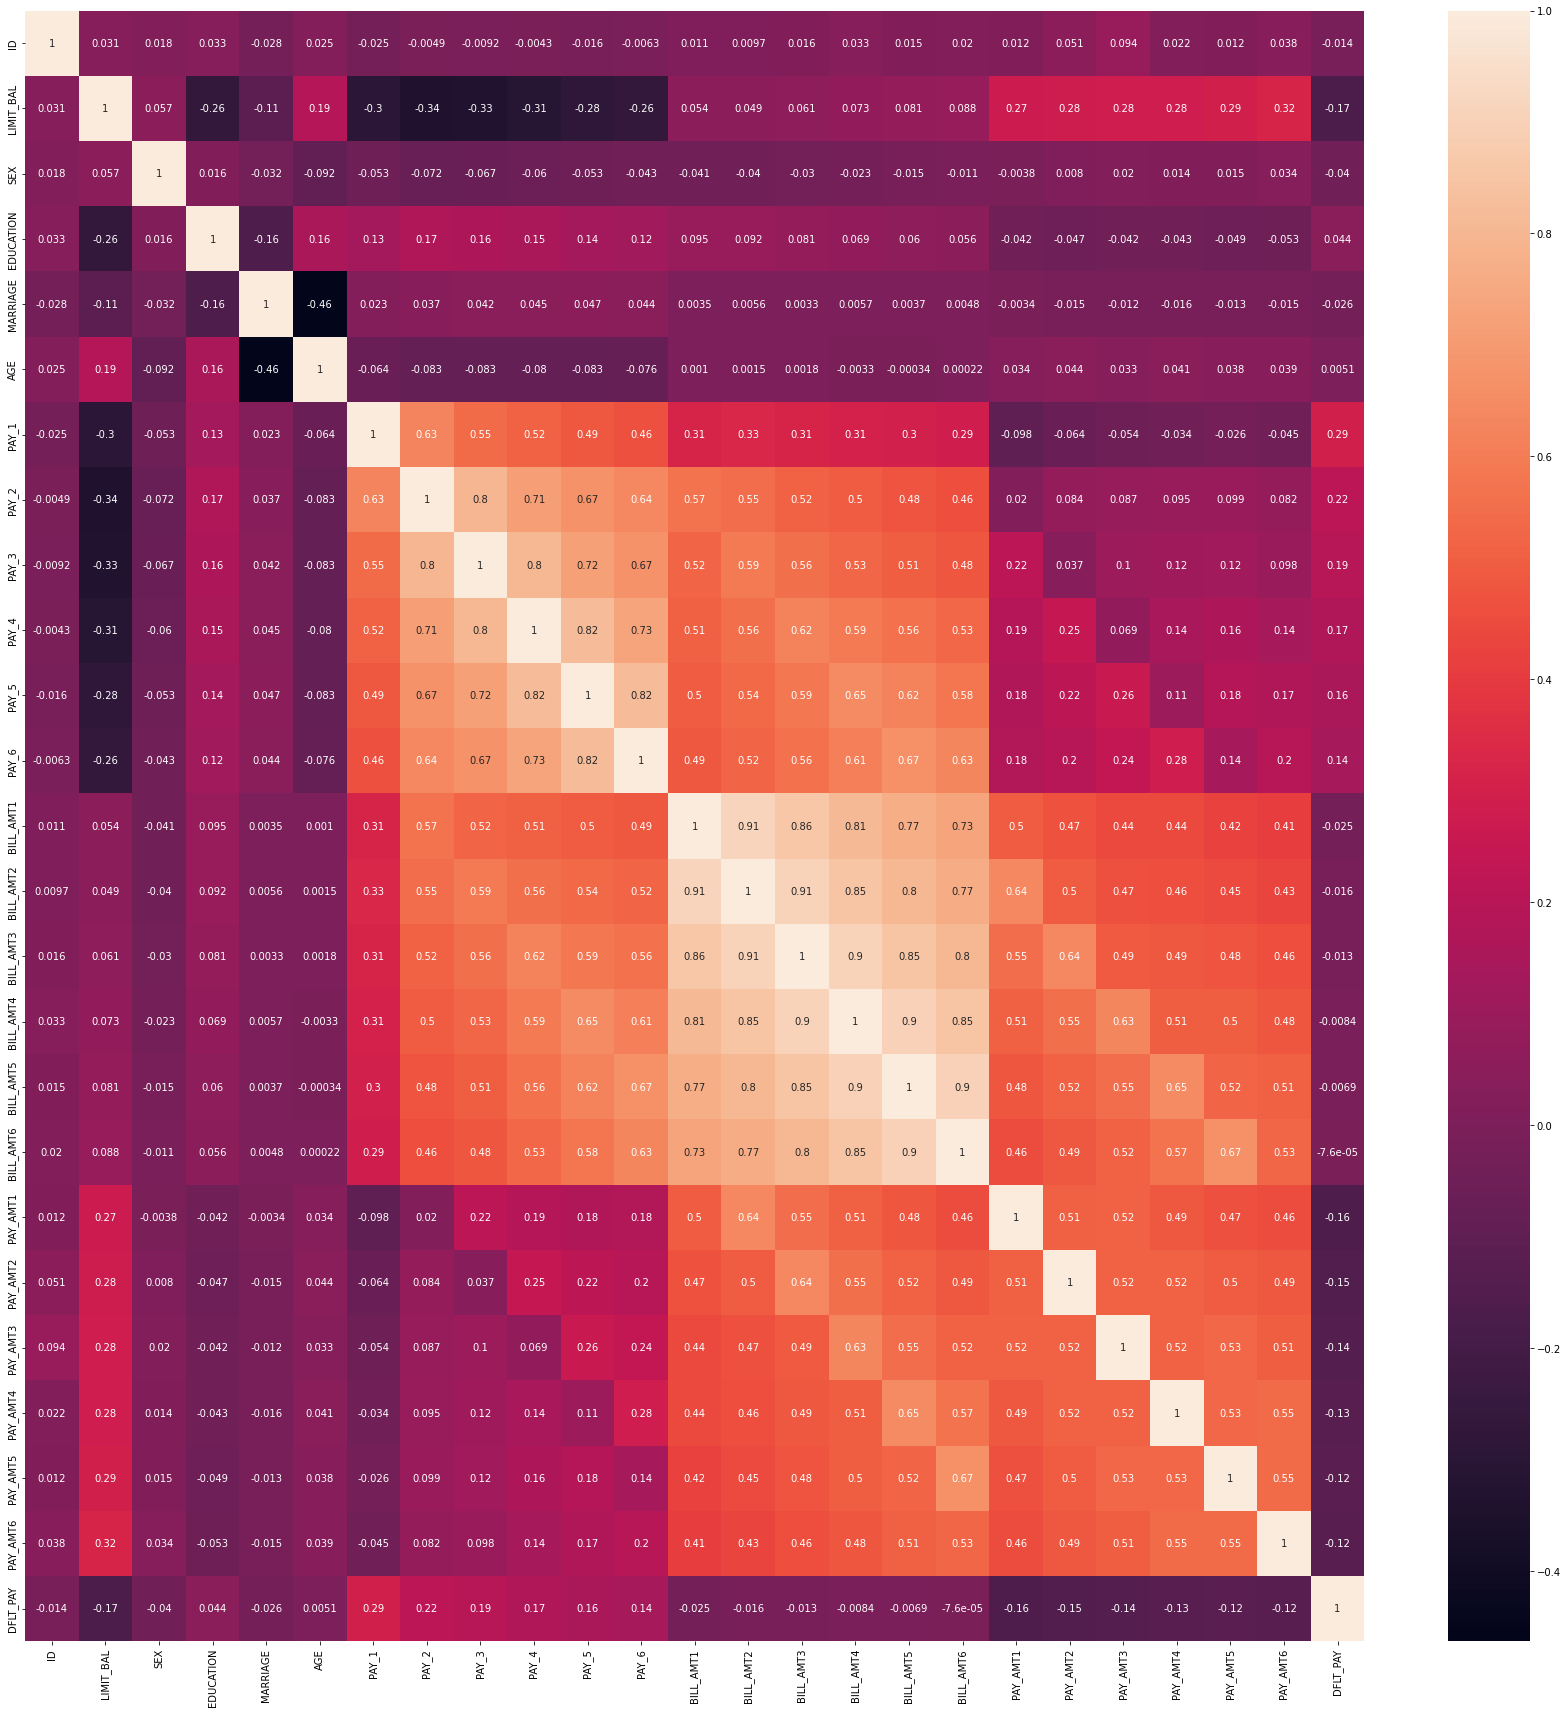

In [19]:
corr_matrix = df.corr(method="spearman")

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True);

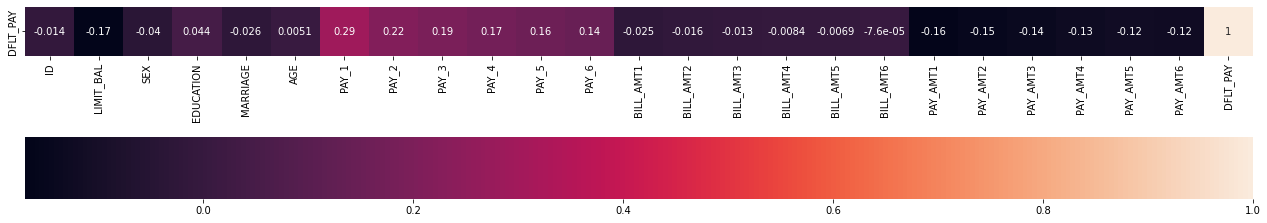

In [20]:
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_matrix[["DFLT_PAY"]].T, annot=True,
    cbar_kws={"orientation": "horizontal"},
    square=True
);

Матрица корреляции показывает, что поле ***DFLT_PAY*** имеет некую положительную корреляцию с полями ***PAY_n***.

Попробуем обучить модель на всех данных. В последующем будем убирать лишние по нашему мнению данные. 

## Обучение с RandomForestClassifier

### Обучение без балансировки

In [21]:
def count_items(arr):
    u, c = np.unique(arr, return_counts=True)
    return dict(zip(u, c))

In [22]:
def aucrp(y_true, y_pred):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    return auc(r, p)

In [45]:
def model_report(y_true, y_pred, labels):
    print("Classification report:")
    print(classification_report(y_true=y_true, y_pred=y_pred))
    print("Accuracy score:", accuracy_score(y_true=y_true, y_pred=y_pred))
    print("AUC RP:", aucrp(y_true=y_true, y_pred=y_pred))
    
    print("\nConfusion matrix")
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, 
        display_labels=labels,
        colorbar=False, normalize="all"
    )

In [46]:
RANDOM_STATE = 42
MAX_DEPTH = 5

In [47]:
X_df, y_df = df.drop(["DFLT_PAY", "ID"], axis=1).to_numpy(), df.DFLT_PAY.to_numpy()

X_df.shape, y_df.shape

((30000, 23), (30000,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.68      0.29      0.41      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.63      0.65      9000
weighted avg       0.80      0.82      0.79      9000

Accuracy score: 0.8155555555555556
AUC RP: 0.561976430315716

Confusion matrix


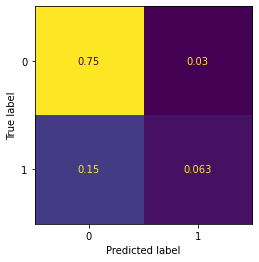

In [49]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

In [50]:
print("Classification report (imbalanced):")
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred))

Classification report (imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.96      0.29      0.89      0.53      0.30      7040
          1       0.68      0.29      0.96      0.41      0.53      0.26      1960

avg / total       0.80      0.82      0.44      0.79      0.53      0.29      9000



Несмотря на то, что точность неплохая, мы можем наблюдать не очень хорошие результаты на матрице ошибок. Так, ошибок первого рода 1394, второго рода -- 266. Не самый хороший результат.

#### Обучение на некоторых признаках

X_df shape: (30000, 10)
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.67      0.36      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

Accuracy score: 0.8221111111111111
AUC RP: 0.5846877649610569

Confusion matrix


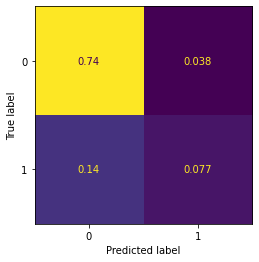

In [51]:
significant_cols = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE"] + [f"PAY_{i}" for i in range(1, 7)]

X_df = df[significant_cols].to_numpy()
print(f"X_df shape: {X_df.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

In [52]:
print("Classification report (imbalanced):")
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred))

Classification report (imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.95      0.36      0.89      0.58      0.36      7040
          1       0.67      0.36      0.95      0.47      0.58      0.32      1960

avg / total       0.80      0.82      0.49      0.80      0.58      0.35      9000



Результат неплохой, попробуем избавиться от следующих данных: ***SEX, EDUCATION, MARRIAGE, AGE***.

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.67      0.36      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

Accuracy score: 0.8218888888888889
AUC RP: 0.5840722393545162

Confusion matrix


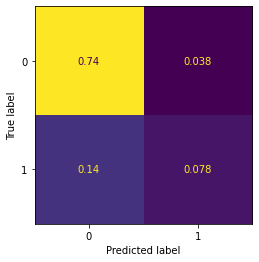

In [53]:
significant_cols = ["LIMIT_BAL"] + [f"PAY_{i}" for i in range(1, 7)]

X_df = df[significant_cols].to_numpy()
X_df.shape

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

Результат не стал значительно хуже, т.е. можно предположить, что исключенные поля не так важны при предсказании модели.

Вспомним, что данные несбалансированы. Попробуем это исправить.

### Обучение с балансировкой

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7040
           1       0.49      0.57      0.53      1960

    accuracy                           0.78      9000
   macro avg       0.68      0.70      0.69      9000
weighted avg       0.79      0.78      0.78      9000

Accuracy score: 0.7794444444444445
AUC RP: 0.5784095944636176

Confusion matrix


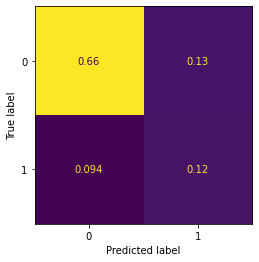

In [54]:
model = BalancedRandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

In [55]:
print("Classification report (imbalanced):")
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred))

Classification report (imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.84      0.57      0.86      0.69      0.49      7040
          1       0.49      0.57      0.84      0.53      0.69      0.46      1960

avg / total       0.79      0.78      0.63      0.78      0.69      0.48      9000



BalancedRandomForestClassifier помог избавиться от части ошибок первого рода, но при этом мы совершаем практически в 4 раза больше ошибок второго рода.
Также предсказательная точность модели упала, но при этом незначительно повысился aucrp.

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7040
           1       0.49      0.57      0.53      1960

    accuracy                           0.78      9000
   macro avg       0.68      0.70      0.69      9000
weighted avg       0.79      0.78      0.78      9000

Accuracy score: 0.7794444444444445
AUC RP: 0.5784095944636176

Confusion matrix


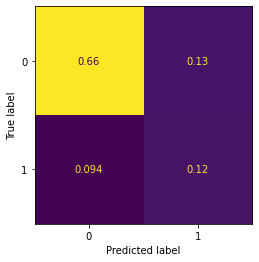

In [56]:
model = BalancedRandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

In [57]:
print("Classification report (imbalanced):")
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred))

Classification report (imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.84      0.57      0.86      0.69      0.49      7040
          1       0.49      0.57      0.84      0.53      0.69      0.46      1960

avg / total       0.79      0.78      0.63      0.78      0.69      0.48      9000



Все вышеприведенные модели работают, но не достаточно хорошо, как хотелось бы, -- они все еще совершают много ошибок первого и второго рода, а значение aucrp чуть больше 0.5.

#### Over- and undersampling

In [58]:
def resample_data(X, y, combine):
    X_resampled, y_resampled = combine.fit_resample(X, y)
    
    print(f"Size of X_df before resampling: {len(X_df)}; after: {len(X_resampled)}")
    print(f"y_df distirbution before: {count_items(y_df)}; after: {count_items(y_resampled)}")
    
    return X_resampled, y_resampled

##### Все признаки

In [59]:
X_df = df.drop(["DFLT_PAY", "ID"], axis=1).to_numpy()
y_df = df.DFLT_PAY.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=RANDOM_STATE)

X_train_r, y_train_r = resample_data(
    X_train, y_train, 
    combine=SMOTEENN(
        random_state=RANDOM_STATE,
        sampling_strategy="auto"
    )
)

Size of X_df before resampling: 30000; after: 21928
y_df distirbution before: {0: 23364, 1: 6636}; after: {0: 8310, 1: 13618}


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.70      4687
           1       0.34      0.78      0.47      1313

    accuracy                           0.62      6000
   macro avg       0.62      0.68      0.59      6000
weighted avg       0.78      0.62      0.65      6000

Accuracy score: 0.6208333333333333
AUC RP: 0.5834284189934423

Confusion matrix


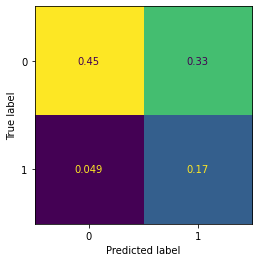

In [60]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train_r, y_train_r)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

In [61]:
print("Classification report (imbalanced):")
print(classification_report_imbalanced(y_true=y_test, y_pred=y_pred))

Classification report (imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.58      0.78      0.70      0.67      0.44      4687
          1       0.34      0.78      0.58      0.47      0.67      0.46      1313

avg / total       0.78      0.62      0.73      0.65      0.67      0.44      6000



##### Некоторые признаки

In [62]:
significant_cols = ["LIMIT_BAL"] + [f"PAY_{i}" for i in range(1, 7)] + [f"PAY_AMT{i}" for i in range(1, 7)]

X_df = df[significant_cols].to_numpy()
print(f"X_df shape: {X_df.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=RANDOM_STATE)

X_train_r, y_train_r = resample_data(
    X_train, y_train, 
    combine=SMOTETomek(
        random_state=RANDOM_STATE,
        sampling_strategy="auto"
    )
)

X_df shape: (30000, 13)
Size of X_df before resampling: 30000; after: 35974
y_df distirbution before: {0: 23364, 1: 6636}; after: {0: 17987, 1: 17987}


In [63]:
X_train_r.shape, y_train_r.shape

((35974, 13), (35974,))

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4687
           1       0.49      0.57      0.53      1313

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

Accuracy score: 0.7765
AUC RP: 0.5776375203504824

Confusion matrix


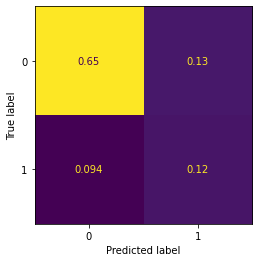

In [64]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train_r, y_train_r)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

Попробуем предсказать только по данным первого месяца.

In [65]:
significant_cols = ["LIMIT_BAL"] + [f"PAY_{i}" for i in range(1, 2)] + [f"PAY_AMT{i}" for i in range(1, 2)]

X_df = df[significant_cols].to_numpy()
print(f"X_df shape: {X_df.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=RANDOM_STATE)

X_train_r, y_train_r = resample_data(
    X_train, y_train, 
    combine=SMOTEENN(
        random_state=RANDOM_STATE,
        sampling_strategy="auto"
    )
)

X_df shape: (30000, 3)
Size of X_df before resampling: 30000; after: 12575
y_df distirbution before: {0: 23364, 1: 6636}; after: {0: 8345, 1: 4230}


Classification report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4687
           1       0.60      0.36      0.45      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

Accuracy score: 0.8083333333333333
AUC RP: 0.5520010809044069

Confusion matrix


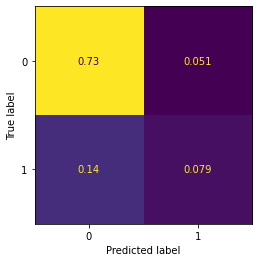

In [66]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
model.fit(X_train_r, y_train_r)

y_pred = model.predict(X_test)

model_report(y_test, y_pred, model.classes_)

Результат тоже неплохой, если сравнивать с прошлыми результатами.

До этого моменты мы использовали леса для предсказания. Попробуем регрессию.

## Обучение с RandomForestRegressor

### Обучение без балансировки

In [81]:
def plot_errors(model, X, y):
    fst_errors, snd_errors = [], []
    thresholds = np.arange(0.05, 1.00, 0.05)
    
    for threshold in thresholds:
        y_pred = (model.predict(X) > threshold).astype(np.uint8)
        
        cm = confusion_matrix(y_true=y, y_pred=y_pred, normalize="all")
        fst_errors.append(cm[1, 0])
        snd_errors.append(cm[0, 1])
        
    plt.plot(thresholds, fst_errors, label="1 error")
    plt.plot(thresholds, snd_errors, label="2 error")
    plt.legend()

In [72]:
X_df, y_df = df.drop(["DFLT_PAY", "ID"], axis=1).to_numpy(), df.DFLT_PAY.to_numpy()
print(f"X_df shape: {X_df.shape}, y_df: {y_df.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

model = RandomForestRegressor(
    random_state=RANDOM_STATE,
    max_depth=MAX_DEPTH
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

X_df shape: (30000, 23), y_df: (30000,)


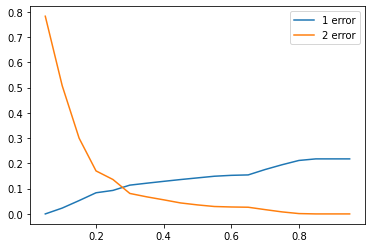

In [73]:
plot_errors(model, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7040
           1       0.56      0.48      0.52      1960

    accuracy                           0.81      9000
   macro avg       0.71      0.69      0.70      9000
weighted avg       0.80      0.81      0.80      9000

Accuracy score: 0.8051111111111111
AUC RP: 0.576414371838479

Confusion matrix


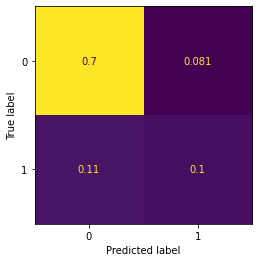

In [82]:
model_report(y_test, (y_pred > 0.3).astype(np.uint8), None)

Результат неплохой.

### Обучение с балансировкой

In [95]:
significant_cols = ["LIMIT_BAL"] + [f"PAY_{i}" for i in range(1, 7)] + [f"PAY_AMT{i}" for i in range(1, 7)]

X_df = df[significant_cols].to_numpy()
print(f"X_df shape: {X_df.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=RANDOM_STATE)

X_train_r, y_train_r = resample_data(
    X_train, y_train, 
    combine=SMOTEENN(
        random_state=RANDOM_STATE,
        sampling_strategy="auto"
    )
)

X_df shape: (30000, 13)
Size of X_df before resampling: 30000; after: 20607
y_df distirbution before: {0: 23364, 1: 6636}; after: {0: 8422, 1: 12185}


In [96]:
model = RandomForestRegressor(
    random_state=RANDOM_STATE,
    max_depth=MAX_DEPTH
)

model.fit(X_train_r, y_train_r)

y_pred = model.predict(X_test)

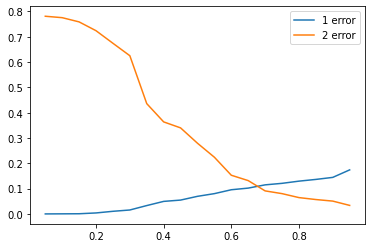

In [97]:
plot_errors(model, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4687
           1       0.55      0.45      0.49      1313

    accuracy                           0.80      6000
   macro avg       0.70      0.67      0.68      6000
weighted avg       0.79      0.80      0.79      6000

Accuracy score: 0.799
AUC RP: 0.5593547521712667

Confusion matrix


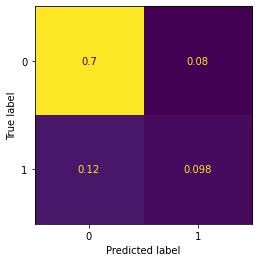

In [105]:
model_report(y_test, (y_pred > 0.75).astype(np.uint8), None)